1. Upload a dataset (`final_dataset1000.jsonl`) and a model (`model_v2.py`, `model_v2_1.py`, `model_v3.py`, `model_v3_1.py`)
2. In `# DATASET PATH` cell, fill `<your_dataset_path>` in `df = pd.read_json('<your_dataset_path>', lines=True)` with the path of the uploaded dataset.
3. In `# import model from .py file here` cell import `<your_model.py>` by `from <your_model> import <the class in your_model.py>`
4. In `# Load model` cell, let `model = <the class in your_model.py>` with proper parameters (model_name and num_classes which should be already provided). Name `model_id` with v2, v2_1, v3 or v3_1 based on the imported .py file.
5. After running all cells, you should see graphs printed. Save the graphs.
6. You should also see other files saved in the files section along with your uploaded dataset file and model file. Save those files: `.json` files and a `.pth` file of the best performed model.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as nn_init
from torch.optim import AdamW
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import json
from sklearn.model_selection import train_test_split

In [2]:
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

In [3]:
# DATASET PATH
df = pd.read_json('/content/final_dataset1000.jsonl', lines=True)
df_combined = df
print(len(df_combined))

13983


In [4]:
# Czech uses Latin characters with diacritics (Latin Extended-A block)
czech_chars = [chr(i) for i in range(0x0100, 0x0180) if chr(i).isprintable()]  # Czech (Latin Extended-A)

# Greek alphabet (Greek and Coptic Unicode block)
greek_chars = [chr(i) for i in range(0x0370, 0x0400) if chr(i).isprintable()]  # Greek

# Hebrew alphabet (Hebrew Unicode block)
hebrew_chars = [chr(i) for i in range(0x0590, 0x0600) if chr(i).isprintable()]  # Hebrew

# Russian alphabet (Cyrillic Unicode block)
russian_chars = [chr(i) for i in range(0x0400, 0x0500) if chr(i).isprintable()]  # Russian (Cyrillic)

# Arabic alphabet (Arabic Unicode block)
arabic_chars = [chr(i) for i in range(0x0600, 0x0700) if chr(i).isprintable()]  # Arabic

# Korean characters (Hangul Syllables Unicode block)
korean_chars = [chr(i) for i in range(0xAC00, 0xD7A4) if chr(i).isprintable()]  # Korean (Hangul syllables)

# Macedonian alphabet (using the Cyrillic Supplement block for uniqueness)
macedonian_chars = [chr(i) for i in range(0x0500, 0x0530) if chr(i).isprintable()]  # Macedonian (Cyrillic Supplement)

# Thai characters (Thai Unicode block)
thai_chars = [chr(i) for i in range(0x0E00, 0x0E80) if chr(i).isprintable()]  # Thai

# Hindi characters (Devanagari Unicode block)
hindi_chars = [chr(i) for i in range(0x0900, 0x0980) if chr(i).isprintable()]  # Hindi (Devanagari)

# Bengali characters (Bengali Unicode block)
bengali_chars = [chr(i) for i in range(0x0980, 0x0A00) if chr(i).isprintable()]  # Bengali

print("Czech:", "".join(czech_chars))
print("Greek:", "".join(greek_chars))
print("Hebrew:", "".join(hebrew_chars))
print("Russian:", "".join(russian_chars))
print("Arabic:", "".join(arabic_chars))
print("Korean:", "".join(korean_chars[:50]))   # output only first 50 for brevity
print("Macedonian:", "".join(macedonian_chars))
print("Thai:", "".join(thai_chars))
print("Hindi:", "".join(hindi_chars))
print("Bengali:", "".join(bengali_chars))


latin_chars = [chr(i) for i in range(0x0020, 0x007B) if chr(i).isprintable()]  # Basic Latin (A-Z, a-z)
chinese_chars = [chr(i) for i in range(0x4E00, 0x9FFF) if chr(i).isprintable()]  # Common Chinese characters

# French uses Latin characters with accents
french_chars = [chr(i) for i in range(0x00C0, 0x0100) if chr(i).isprintable()]  # À-ÿ (includes é, è, ç, etc.)

# Japanese includes Hiragana, Katakana
hiragana_chars = [chr(i) for i in range(0x3041, 0x30A0) if chr(i).isprintable()]  # Hiragana
katakana_chars = [chr(i) for i in range(0x30A1, 0x3100) if chr(i).isprintable()]  # Katakana



# Combine all characters and verify uniqueness
unique_chars = set("".join(
    czech_chars + greek_chars + hebrew_chars + russian_chars +
    arabic_chars + korean_chars + macedonian_chars + thai_chars +
    hindi_chars + bengali_chars + latin_chars + chinese_chars +
    french_chars + hiragana_chars + katakana_chars
))
print(len(unique_chars))
print(len(unique_chars) == len(czech_chars) + len(greek_chars) + len(hebrew_chars) +
      len(russian_chars) + len(arabic_chars) + len(korean_chars) + len(macedonian_chars) +
      len(thai_chars) + len(hindi_chars) + len(bengali_chars) + len(latin_chars) +
      len(chinese_chars) + len(french_chars) + len(hiragana_chars) + len(katakana_chars))


Czech: ĀāĂăĄąĆćĈĉĊċČčĎďĐđĒēĔĕĖėĘęĚěĜĝĞğĠġĢģĤĥĦħĨĩĪīĬĭĮįİıĲĳĴĵĶķĸĹĺĻļĽľĿŀŁłŃńŅņŇňŉŊŋŌōŎŏŐőŒœŔŕŖŗŘřŚśŜŝŞşŠšŢţŤťŦŧŨũŪūŬŭŮůŰűŲųŴŵŶŷŸŹźŻżŽžſ
Greek: ͰͱͲͳʹ͵Ͷͷͺͻͼͽ;Ϳ΄΅Ά·ΈΉΊΌΎΏΐΑΒΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩΪΫάέήίΰαβγδεζηθικλμνξοπρςστυφχψωϊϋόύώϏϐϑϒϓϔϕϖϗϘϙϚϛϜϝϞϟϠϡϢϣϤϥϦϧϨϩϪϫϬϭϮϯϰϱϲϳϴϵ϶ϷϸϹϺϻϼϽϾϿ
Hebrew: ְֱֲֳִֵֶַָֹֺֻּֽ֑֖֛֢֣֤֥֦֧֪֚֭֮֒֓֔֕֗֘֙֜֝֞֟֠֡֨֩֫֬֯־ֿ׀ׁׂ׃ׅׄ׆ׇאבגדהוזחטיךכלםמןנסעףפץצקרשתׯװױײ׳״
Russian: ЀЁЂЃЄЅІЇЈЉЊЋЌЍЎЏАБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяѐёђѓєѕіїјљњћќѝўџѠѡѢѣѤѥѦѧѨѩѪѫѬѭѮѯѰѱѲѳѴѵѶѷѸѹѺѻѼѽѾѿҀҁ҂҃҄҅҆҇҈҉ҊҋҌҍҎҏҐґҒғҔҕҖҗҘҙҚқҜҝҞҟҠҡҢңҤҥҦҧҨҩҪҫҬҭҮүҰұҲҳҴҵҶҷҸҹҺһҼҽҾҿӀӁӂӃӄӅӆӇӈӉӊӋӌӍӎӏӐӑӒӓӔӕӖӗӘәӚӛӜӝӞӟӠӡӢӣӤӥӦӧӨөӪӫӬӭӮӯӰӱӲӳӴӵӶӷӸӹӺӻӼӽӾӿ
Arabic: ؆؇؈؉؊؋،؍؎؏ؘؙؚؐؑؒؓؔؕؖؗ؛؝؞؟ؠءآأؤإئابةتثجحخدذرزسشصضطظعغػؼؽؾؿـفقكلمنهوىيًٌٍَُِّْٕٖٜٟٓٔٗ٘ٙٚٛٝٞ٠١٢٣٤٥٦٧٨٩٪٫٬٭ٮٯٰٱٲٳٴٵٶٷٸٹٺٻټٽپٿڀځڂڃڄڅچڇڈډڊڋڌڍڎڏڐڑڒړڔڕږڗژڙښڛڜڝڞڟڠڡڢڣڤڥڦڧڨکڪګڬڭڮگڰڱڲڳڴڵڶڷڸڹںڻڼڽھڿۀہۂۃۄۅۆۇۈۉۊۋیۍێۏېۑےۓ۔ەۖۗۘۙۚۛۜ۞ۣ۟۠ۡۢۤۥۦۧۨ۩۪ۭ۫۬ۮۯ۰۱۲۳۴۵۶۷۸۹ۺۻۼ۽۾ۿ
Korean: 가각갂갃간갅갆갇갈갉갊갋갌갍갎갏감갑값갓갔강갖갗갘같갚갛개객갞갟갠갡갢갣갤갥갦갧갨갩갪갫갬갭갮갯갰갱
Macedonian: ԀԁԂԃԄԅԆԇԈԉԊԋԌԍԎԏԐԑԒԓԔԕԖԗԘԙԚԛԜԝ

In [5]:
# manually extra
unique_chars.add("¦")
unique_chars.add('\u3000')
unique_chars.add('、')
unique_chars.add('。')
unique_chars.add('？')
unique_chars.add('！')
unique_chars.add('「')
unique_chars.add('」')
unique_chars.add('『')
unique_chars.add('』')
unique_chars.add('《')
unique_chars.add('》')
unique_chars.add('－')
unique_chars.add('０')
unique_chars.add('々')
unique_chars.add('♪')
unique_chars.add('¿')
unique_chars.add('\x87')
unique_chars.add('\u200d')
print(len(unique_chars))

33739


In [6]:
for text in df_combined['text']:
    unique_chars.update(text)

In [7]:
# Define large Unicode character mapping
char_to_idx = {char: idx for idx, char in enumerate(unique_chars)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}
num_classes = len(unique_chars)
print(num_classes)

33884


In [8]:
# Function to split the text in the middle and extract the input and label
def split_text(row):
    text = row['text']
    mid_point = len(text) // 2

    input_text = text[:mid_point]
    label_text = text[mid_point:]

    label = label_text[0] if len(label_text) > 0 else ""

    return pd.Series([input_text, label])

# Apply the function and assign to new columns
df_combined[['input', 'label']] = df_combined.apply(split_text, axis=1)

def tokenize_text(text):
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
    return tokenizer(text, padding=True, truncation=True, max_length=50, return_tensors="pt")
def label_to_idx(label):
    return char_to_idx[label]

# Apply the tokenizer to the 'text' column and store the tokenized results
df_combined['tokenized_input'] = df_combined['input'].apply(lambda x: tokenize_text(x))
df_combined['label_idx'] = df_combined['label'].apply(lambda x: label_to_idx(x))
df_combined['input_ids'] = df_combined['tokenized_input'].apply(lambda x: x['input_ids'].squeeze(0))
df_combined['attention_mask'] = df_combined['tokenized_input'].apply(lambda x: x['attention_mask'].squeeze(0))
df_combined.drop(columns=['tokenized_input'], inplace=True)
df_combined = df_combined.reset_index(drop=True)
print(df_combined.head())
print(df_combined.iloc[0]['input_ids'])

  language                                               text  \
0   Arabic                                           ‏‫حسنًا.   
1   Arabic        أعرف ان كتابة المخططات ليس ممتعاً كالجراحات   
2   Arabic                          هاك. إرتدِ هذا, هلا فعلت؟   
3   Arabic  محاولاً الحصول على فكرة بينما تخرج زوجتي من ال...   
4   Arabic                                                  !   

                       input label  label_idx  \
0                       ‏‫حس     ن      22889   
1      أعرف ان كتابة المخططا     ت       3516   
2               هاك. إرتدِ ه     ذ      15711   
3  محاولاً الحصول على فكرة ب     ي      14014   
4                                !      27721   

                                           input_ids  \
0  [tensor(0), tensor(12106), tensor(3247), tenso...   
1  [tensor(0), tensor(1333), tensor(48753), tenso...   
2  [tensor(0), tensor(917), tensor(972), tensor(5...   
3  [tensor(0), tensor(63050), tensor(40286), tens...   
4                             [ten

In [9]:
train_df, val_df = train_test_split(df_combined, test_size=0.2, random_state=42)
print(len(train_df))
print(len(val_df))

11186
2797


In [10]:
"""
Usage:
dataset = TextDataset(df)
dataloader = DataLoader(dataset, batch_size=<x>, shuffle=True)
"""

class TextDataset(Dataset):
    def __init__(self, df):
        self.input_ids = df['input_ids'].tolist()
        self.attention_mask = df['attention_mask'].tolist()
        self.labels = df['label_idx'].tolist()
        self.language = df['language'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        input_ids = self.input_ids[idx]
        attention_mask = self.attention_mask[idx]
        label = self.labels[idx]
        language = self.language[idx]

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label),
            'language': language
        }

In [11]:
# import model from .py file here
from model_v2 import UnicodeClassifier_v2

In [12]:
class UnicodeClassifier(nn.Module):
    def __init__(self, model_name, num_classes, freeze_encoder = True):
        super(UnicodeClassifier, self).__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.fc1 = nn.Linear(self.encoder.config.hidden_size, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu2 = nn.ReLU()
        self.fc = nn.Linear(256, num_classes)  # Large Unicode classification head

        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.fc.modules():
            if isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)  # gamma to 1
                m.bias.data.zero_()     # beta to 0
            elif isinstance(m, nn.Linear):
                nn_init.xavier_uniform_(m.weight)  # Xavier initialization
                if m.bias is not None:
                    m.bias.data.zero_()  # bias to 0

    def forward(self, input_ids: torch.tensor, attention_mask: torch.tensor):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        outputs = self.relu1(self.fc1(outputs.last_hidden_state[:, 0, :]))
        outputs = self.relu2(self.fc2(outputs))
        logits = self.fc(outputs)  # CLS token output
        return logits

In [13]:
class TopKLoss(nn.Module):
    def __init__(self):
        super(TopKLoss, self).__init__()
        self.ce_loss = nn.CrossEntropyLoss()

    def forward(self, logits, target):
        loss = self.ce_loss(logits, target)

        return loss

In [14]:
def collate_fn(batch):
    """
    Custom collate function to pad sequences within a batch.
    """
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = torch.tensor([item['labels'] for item in batch])
    languages = [item['language'] for item in batch]

    # Pad input_ids and attention_mask
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels,
        'language': languages  # Assuming you need language information
    }

In [15]:
def evaluate(
    model: nn.Module,
    df_val: pd.DataFrame,
    collate_fn,
    eval_batch_size: int = 128,
    criterion: nn.Module = TopKLoss(),
    top_k: int = 3,
    device: str = "cpu",
):
    """
    Evaluate the model's loss on the validation set, also accuracy
    """
    dataset = TextDataset(df_val)
    val_dataloader = DataLoader(dataset, batch_size=eval_batch_size, collate_fn=collate_fn, shuffle=False)

    model.eval()
    model.to(device)

    val_loss = 0.0
    val_correct, val_samples = 0, 0

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids_batch = batch['input_ids'].to(device)
            attention_mask_batch = batch['attention_mask'].to(device)
            y_batch = batch['labels'].to(device)

            y_batch_pred = model(input_ids_batch, attention_mask_batch)
            batch_loss = criterion(y_batch_pred, y_batch)

            top_k_probs, top_k_indices = torch.topk(y_batch_pred, k=top_k, dim=-1)
            batch_preds = [([idx.item() for idx in i]) for i in top_k_indices.cpu()]

            val_loss += batch_loss.item()
            batch_preds_tensor = torch.tensor(batch_preds, device=device)
            correct = (batch_preds_tensor == y_batch.view(-1, 1)).any(dim=1).float()
            val_correct += correct.sum().item()
            val_samples += len(batch_preds)

    val_loss /= len(val_dataloader)
    acc = float(val_correct) / val_samples

    return {"val_loss": val_loss, "val_acc": acc}



In [16]:
def train(
    model: nn.Module,
    df_train: pd.DataFrame,
    df_val: pd.DataFrame,
    collate_fn,
    lr: float = 1e-3,
    criterion: nn.Module = TopKLoss(),
    batch_size: int = 32,
    eval_batch_size: int = 128,
    num_epochs: int = 10,
    top_k: int = 3,
    device: str = "cpu",
    verbose: bool = True,
):
    """
    Run training loop for `n_epochs` epochs.
    """
    dataset = TextDataset(df_train)
    train_dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=True,
    )

    model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr)

    train_metrics = []
    val_metrics = []
    train_correct, train_samples = 0, 0

    for epoch in range(num_epochs):
        model.train()
        train_epoch_loss = 0.0
        for batch in train_dataloader:
            input_ids_batch = batch['input_ids'].to(device)
            attention_mask_batch = batch['attention_mask'].to(device)
            y_batch = batch['labels'].to(device)

            optimizer.zero_grad()
            y_batch_pred = model(input_ids_batch, attention_mask_batch)
            batch_loss = criterion(y_batch_pred, y_batch)
            batch_loss.backward()
            optimizer.step()

            top_k_probs, top_k_indices = torch.topk(y_batch_pred, k=top_k, dim=-1)
            batch_preds = [([idx.item() for idx in i]) for i in top_k_indices.cpu()]

            train_epoch_loss += batch_loss.item()
            batch_preds_tensor = torch.tensor(batch_preds, device=device)
            correct = (batch_preds_tensor == y_batch.view(-1, 1)).any(dim=1).float()
            train_correct += correct.sum().item()
            train_samples += len(batch_preds)

        # train loss
        train_epoch_loss /= len(train_dataloader)

        # train acc
        train_acc = float(train_correct) / train_samples

        train_metrics.append({"train_loss": train_epoch_loss, "train_acc": train_acc})

        # val loss and acc
        eval_metrics = evaluate(model, df_val, collate_fn, eval_batch_size, criterion, top_k, device)
        val_metrics.append(eval_metrics)

        if verbose:
            print("Epoch: %.d, Train Loss: %.4f, Train Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f" % (epoch+1, train_epoch_loss, train_acc, eval_metrics["val_loss"], eval_metrics["val_acc"]))

    return train_metrics, val_metrics


In [17]:
# Load model
model = UnicodeClassifier_v2(model_name, num_classes)
model_id = "v2" # v2, v2_1, v3, v3_1

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [18]:
# hyper parameters
lrs = [1e-1, 1e-3, 1e-5]

criterion = TopKLoss() # a new one?
batch_sizes = [32, 64, 128]
eval_batch_size = 128
num_epochs = 7
top_k = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
import matplotlib.pyplot as plt

def plot_metrics(train_metrics, val_metrics, setup):
  train_loss = [m['train_loss'] for m in train_metrics]
  train_acc = [m['train_acc'] for m in train_metrics]
  val_loss = [m['val_loss'] for m in val_metrics]
  val_acc = [m['val_acc'] for m in val_metrics]
  epochs = range(1, len(train_loss) + 1)

  def draw_plot(x, y1, y2, title, setup):
    plt.plot(x, y1, label = 'train', marker='o', linestyle='-')
    plt.plot(x, y2, label = 'val', marker='s', linestyle=':')
    plt.xlabel('Epochs')
    plt.ylabel(f'{title}')
    plt.title(f'{setup}')
    plt.legend()
    plt.show()

  draw_plot(epochs, train_loss, val_loss, 'Loss', setup)
  draw_plot(epochs, train_acc, val_acc, 'Accuracy', setup)


Epoch: 1, Train Loss: 6.9935, Train Acc: 0.1785, Val Loss: 5.8750, Val Acc: 0.1866
Epoch: 2, Train Loss: 5.6890, Train Acc: 0.1818, Val Loss: 5.7927, Val Acc: 0.1866
Epoch: 3, Train Loss: 5.6061, Train Acc: 0.1825, Val Loss: 5.7785, Val Acc: 0.1873
Epoch: 4, Train Loss: 5.5622, Train Acc: 0.1825, Val Loss: 5.7698, Val Acc: 0.1888
Epoch: 5, Train Loss: 5.5375, Train Acc: 0.1830, Val Loss: 5.7593, Val Acc: 0.1873


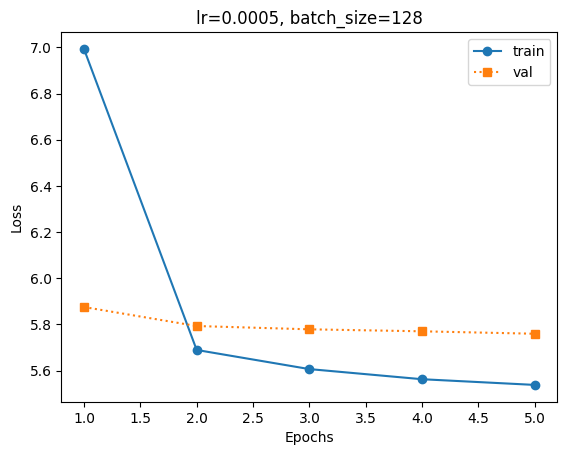

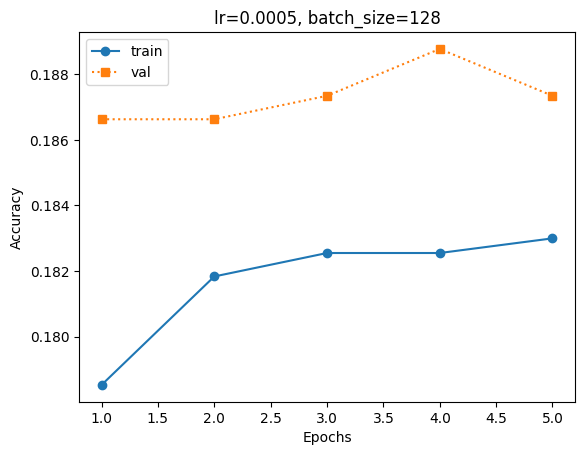

In [20]:
# DON'T forget to record the model name!!! => for a specific model with diff hyper parameters
for lr in lrs:
  for batch_size in batch_sizes:
    setup = f'lr={lr}, batch_size={batch_size}'
    train_metrics, val_metrics = train(model, train_df, val_df, collate_fn, lr, criterion, batch_size, eval_batch_size, num_epochs, top_k, device)
    plot_metrics(train_metrics, val_metrics, setup)
    torch.save(model.state_dict(), f'{model_id}{setup}.pth')
    with open(f"{model_id}{setup}.json", "w") as f:
      json.dump(train_metrics, f, indent=4)

In [ ]:
# train(model, train_df, val_df, collate_fn, lrs[-1], criterion, batch_sizes[-1], eval_batch_size, num_epochs, top_k, device)

Epoch: 1, Train Loss: 7.1796, Train Acc: 0.1688, Val Loss: 5.6774, Val Acc: 0.1917
Epoch: 2, Train Loss: 5.3240, Train Acc: 0.1757, Val Loss: 5.6344, Val Acc: 0.1975
Epoch: 3, Train Loss: 5.1816, Train Acc: 0.1780, Val Loss: 5.5420, Val Acc: 0.1983
Epoch: 4, Train Loss: 5.0887, Train Acc: 0.1785, Val Loss: 5.5000, Val Acc: 0.1983
Epoch: 5, Train Loss: 5.0064, Train Acc: 0.1811, Val Loss: 5.4632, Val Acc: 0.2133
Epoch: 6, Train Loss: 4.9302, Train Acc: 0.1830, Val Loss: 5.4300, Val Acc: 0.2108
Epoch: 7, Train Loss: 4.8848, Train Acc: 0.1851, Val Loss: 5.4646, Val Acc: 0.2058
Epoch: 8, Train Loss: 4.8401, Train Acc: 0.1873, Val Loss: 5.3962, Val Acc: 0.2108
Epoch: 9, Train Loss: 4.8241, Train Acc: 0.1887, Val Loss: 5.3574, Val Acc: 0.2133
Epoch: 10, Train Loss: 4.7883, Train Acc: 0.1898, Val Loss: 5.3591, Val Acc: 0.2142


([{'train_loss': 7.1795973777771, 'train_acc': 0.16875},
  {'train_loss': 5.32397946357727, 'train_acc': 0.17572916666666666},
  {'train_loss': 5.181610829035441, 'train_acc': 0.17798611111111112},
  {'train_loss': 5.088727509180705, 'train_acc': 0.17854166666666665},
  {'train_loss': 5.006448224385579, 'train_acc': 0.18108333333333335},
  {'train_loss': 4.930213985443115, 'train_acc': 0.18302083333333333},
  {'train_loss': 4.88483091990153, 'train_acc': 0.1850892857142857},
  {'train_loss': 4.840064673423767, 'train_acc': 0.187265625},
  {'train_loss': 4.824142980575561, 'train_acc': 0.18872685185185184},
  {'train_loss': 4.788279088338216, 'train_acc': 0.18975}],
 [{'val_loss': 5.677365446090699, 'val_acc': 0.19166666666666668},
  {'val_loss': 5.634439992904663, 'val_acc': 0.1975},
  {'val_loss': 5.54199185371399, 'val_acc': 0.19833333333333333},
  {'val_loss': 5.50003399848938, 'val_acc': 0.19833333333333333},
  {'val_loss': 5.463212490081787, 'val_acc': 0.21333333333333335},
  {'va

In [ ]:
# torch.save(model.state_dict(), f'tiny_model.pth')

In [23]:
# examples
texts = ["Happ", "Happy Ne", "Happy New Yea", "That's one small ste", "That's one sm", "That'", "Th", "one giant leap for mankin", "one giant leap fo", "one giant lea", "one giant l", "one gia", "on"]

In [24]:
# Example text input (Inference)
for text in texts:
  inputs = tokenizer(text, return_tensors="pt")

  # Forward pass
  logits = model(inputs["input_ids"].to(device), inputs["attention_mask"].to(device))

  top_k = 3
  top_k_probs, top_k_indices = torch.topk(logits.cpu(), k=top_k, dim=-1)
  ii = [([idx.item() for idx in i]) for i in top_k_indices]
  top_k_chars = ["".join([idx_to_char[idx.item()] for idx in i]) for i in top_k_indices]
  print(f"Top {top_k} predicted characters: {top_k_chars}")

Top 3 predicted characters: [' eo']
Top 3 predicted characters: [' eo']
Top 3 predicted characters: [' eo']
Top 3 predicted characters: [' eo']
Top 3 predicted characters: [' eo']
Top 3 predicted characters: [' eo']
Top 3 predicted characters: [' eo']
Top 3 predicted characters: [' eo']
Top 3 predicted characters: [' eo']
Top 3 predicted characters: [' eo']
Top 3 predicted characters: [' eo']
Top 3 predicted characters: [' eo']
Top 3 predicted characters: [' eo']
